In [1]:
%matplotlib inline

import pyarrow.parquet as pq
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
df_orig = pq.read_table('PDFMalware2022.parquet').to_pandas()
df_orig.drop(columns=["FileName"], inplace=True)
df_orig.drop(columns=["PageNo", "Encrypt", "EmbeddedFile", "Endobj"], inplace=True) # possible duplicates of Pages, isEncrypted, EmbeddedFiles

In [3]:
df_orig.head()

,PdfSize,MetadataSize,Pages,XrefLength,TitleCharacters,isEncrypted,EmbeddedFiles,Images,Text,Header,...,Javascript,AA,OpenAction,Acroform,JBIG2Decode,RichMedia,Launch,XFA,Colors,Class
0,8.0,180.0,1.0,11.0,0.0,0.0,0.0,0,No,\t%PDF-1.3,...,1,0,1,0,0,0,0,0,0.0,Malicious
1,15.0,224.0,0.0,20.0,7.0,0.0,0.0,0,No,\t%PDF-1.6,...,0,0,0,1,0,0,0,1,0.0,Malicious
2,4.0,468.0,2.0,13.0,16.0,0.0,0.0,0,Yes,\t%PDF-1.3,...,2,0,1,0,0,0,0,0,0.0,Malicious
3,17.0,250.0,1.0,15.0,0.0,0.0,0.0,0,No,\t%PDF-1.3,...,3,0,1,1,0,0,0,0,0.0,Malicious
4,7.0,252.0,3.0,16.0,45.0,0.0,0.0,0,Yes,\t%PDF-1.3,...,2,0,1,0,0,0,0,0,0.0,Malicious


In [4]:
df_orig['Class'].value_counts()

Class
Malicious    5555
Benign       4468
Name: count, dtype: int64

In [5]:
from pyreal.transformers import Transformer, OneHotEncoder, MultiTypeImputer, fit_transformers, run_transformers, BoolToIntCaster

# Manual transformations ----------------------------------------
cat_cols = ["Text", "Header", "Class"]
cols_to_fix = df_orig.select_dtypes(exclude='number').columns
cols_to_fix = [col for col in cols_to_fix if col not in cat_cols]

df = df_orig.copy()

for col in cols_to_fix:
    df[col] = pd.to_numeric(df_orig[col], errors='coerce')

df['Text'] = df_orig['Text'].apply(lambda x: 1 if x == 'Yes' else 0 if x == 'No' else None)

def features_from_header(header):
    error_strings = ["error", "errno", "exception", "fail", "invalid", "null", "problem", "warn", "warning", "not found"]
    error = any(err in header.lower() for err in error_strings)
    standard_headers = ["\t%PDF-1.3","\t%PDF-1.4","\t%PDF-1.7","\t%PDF-1.6","\t%PDF-1.2","\t%PDF-1.5","\t%PDF-1.0","\t%PDF-1.1"]
    standard = any(std in header for std in standard_headers)
    return error, standard

df[["header_error", "header_standard"]] = df_orig[["Header"]].apply(lambda row: features_from_header(row.squeeze()), axis='columns', result_type='expand')
df = df.drop(columns='Header')
df.head()
    
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='Class'), df['Class'], test_size=0.2, random_state=42)

# Additional Pyreal transformations -------------------------------
imputer = MultiTypeImputer()
bool_to_int = BoolToIntCaster()
transformers = [imputer, bool_to_int]

X_train_trans = fit_transformers(transformers, X_train)
X_test_trans = run_transformers(transformers, X_test)

# convert t_test from ["Benign", "Malware"] to [0, 1]
y_train = y_train.apply(lambda x: 0 if x == "Benign" else 1)
y_test = y_test.apply(lambda x: 0 if x == "Benign" else 1)


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [6]:
import pycaret.classification as pc

df_train = X_train_trans.copy()
df_train['Class'] = y_train

exp = pc.ClassificationExperiment()

exp.setup(data=df_train, target='Class')
exp.models()
best = exp.compare_models(sort='AUC', include=["rf", "dt"])

,Description,Value
0,Session id,1616
1,Target,Class
2,Target type,Binary
3,Original data shape,"(8018, 29)"
4,Transformed data shape,"(8018, 29)"
5,Transformed train set shape,"(5612, 29)"
6,Transformed test set shape,"(2406, 29)"
7,Numeric features,28
8,Preprocess,True
9,Imputation type,simple


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,15:06:44
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9941,0.9996,0.9939,0.9955,0.9947,0.9881,0.9881,1.0170
dt,Decision Tree Classifier,0.9877,0.9877,0.9875,0.9904,0.9889,0.9751,0.9752,0.4080


In [7]:
best

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       monotonic_cst=None, n_estimators=100, n_jobs=-1,
                       oob_score=False, random_state=1616, verbose=0,
                       warm_start=False)

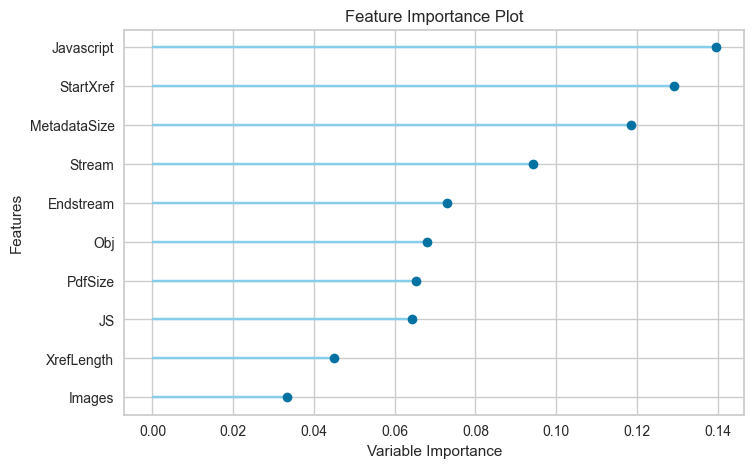

In [8]:
exp.plot_model(best, plot="feature")

In [9]:
exp.get_config('pipeline')

Pipeline(memory=FastMemory(location=C:\Users\Ola\AppData\Local\Temp\joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['PdfSize', 'MetadataSize', 'Pages',
                                             'XrefLength', 'TitleCharacters',
                                             'isEncrypted', 'EmbeddedFiles',
                                             'Images', 'Text', 'Obj', 'Stream',
                                             'Endstream', 'Xref', 'Trailer',
                                             'StartXref', 'ObjStm', 'JS',
                                             'Javascript', 'AA', 'OpenAc...
                                    transformer=SimpleImputer(add_indicator=False,
                                                              copy=True,
                                                              fill_value=None,
                                                              keep_empty_features=False,
                                                              missing_values=nan,
                                                              strategy='mean'))),
                ('categorical_imputer',
                 TransformerWrapper(exclude=None, include=[],
                                    transformer=SimpleImputer(add_indicator=False,
                                                              copy=True,
                                                              fill_value=None,
                                                              keep_empty_features=False,
                                                              missing_values=nan,
                                                              strategy='most_frequent')))],
         verbose=False)

In [10]:
feature_descriptions = {
    'PdfSize':'Total size in KB', 
    'MetadataSize':'Size of metadata in KB', 
    'Pages':'Number of pages',
    'XrefLength':'Number of entries in Xref tables',
    'TitleCharacters':'Number of characters in the title',
    'isEncrypted':'Encryption status',
    'EmbeddedFiles':'Number of embedded files',
    'Images':'Number of images',
    'Text':'Contains text',
    'Header':'Header',
    'header_error':'Header contains error',
    'header_standard':'Header is standard',
    'Obj':'Number of objects',
    'Stream':'Number of streams (sequences of binary data)',
    'Endstream':'Number of keywords that denote end of streams',
    'Xref':'Number of Xref tables',
    'Trailer':'Number of trailers',
    'StartXref':'Number of keywords with startxref',
    'ObjStm':'Number of streams that contain other objects',
    'JS':'Number of JS keywords',
    'Javascript':'Number of Javascript keywords',
    'AA':'Number of AA keywords',
    'OpenAction':'Number of OpenAction keywords',
    'Acroform':'Number of Acroform tags',
    'JBIG2Decode':'Presence of JBIG2Decode filter',
    'RichMedia':'Number of RichMedia keywords',
    'Launch':'Number of Launch keywords',
    'XFA':'Number of XFA keywords',
    'Colors':'Number of unique colors used',
}

In [11]:
from pyreal import RealApp

app = RealApp(best, X_train_orig=X_train_trans, y_train=y_train,
              feature_descriptions=feature_descriptions, pred_format_func=lambda x: "Benign" if x == 0 else "Malware")

#importances = app.produce_feature_importance()

<Axes: >

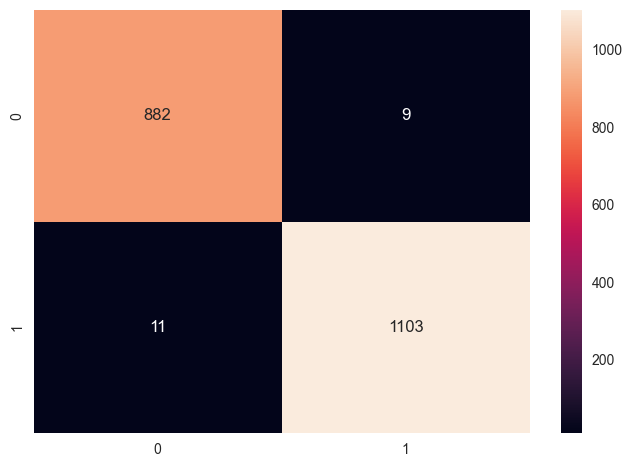

In [12]:
preds = app.predict(X_test, as_dict=False, format=False)

# plot a confusion matrix of preds vs y_test
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, preds)
sns.heatmap(cm, annot=True, fmt='d')

In [13]:
from pyreal.visualize import feature_bar_plot

#feature_bar_plot(importances)

In [14]:
benign_examples = X_train[y_train == 0].sample(100, random_state=42)
malware_examples = X_train[y_train == 1].sample(100, random_state=42)

benign_contributions = app.produce_feature_contributions(benign_examples, shap_type='tree')
malware_contributions = app.produce_feature_contributions(malware_examples, shap_type='tree')

In [16]:
num_to_save = 3

for i, (ben, mal) in enumerate(zip(benign_contributions, malware_contributions)):
    benign_contributions[ben].sort_values(by="Contribution", axis=0, ascending=False, key=abs).to_csv(f'pdf_benign_{i}.csv')
    malware_contributions[mal].sort_values(by="Contribution", axis=0, ascending=False, key=abs).to_csv(f'pdf_malware_{i}.csv')
    num_to_save -= 1
    if num_to_save == 0:
        break